#Tugas Besar PCD Kelompok 1
#IF-45-DSIS03

#Klasifikasi  Gestur Digit Bahasa Isyarat Menggunakan Ekstraksi Ciri Multi-Domain Berbasis Pengolahan Citra  dan  Support Vector Machine


*   Joshua Pinem - 1301223051
*   Imelda Damayanti - 1301223287
*   Firza Fernanda Shakti - 1301220151




#Pendahuluan

Dataset yang dipilih adalah **Sign Languages Dataset**, yang bisa ditemukan secara publik di Kaggle yang dikembangkan oleh siswa dari Turkey Ankara Ayranci Anadolu High School. Dataset ini berisi citra tangan yang menunjukkan angka dari 0 hingga 9, yang masing-masing direpresentasikan dalam bentuk gambar grayscale berukuran 64x64 pixel. Terdapat lebih dari 2000 gambar dalam dataset ini, dengan variasi posisi tangan dari banyak individu yang berbeda, sehingga mencerminkan keragaman nyata dalam penggunaan bahasa isyarat.

##LOAD DATASET

Sebelum dataset bisa diolah dan digunakan, pertama harus kita load dulu kedalam notebook ini. Sebelumnya, dataset telah didownload dan juga di upload ke Google Drive jadi tinggal diunduh saja dari Drive tersebut

In [ ]:
# Mengunduh dataset yang sudah di upload di Google Drive

import gdown

file_id = "19vhcawNyURr1-Xo6FFkh9KsZzvLLGuSz"
output = "dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=19vhcawNyURr1-Xo6FFkh9KsZzvLLGuSz
To: /content/dataset.zip
100%|██████████| 17.6M/17.6M [00:00<00:00, 27.5MB/s]


'dataset.zip'

In [ ]:
# Melakukan import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import ndimage
import time
import os


In [ ]:
# Fungsi untuk menampilkan beberapa gambar dalam satu baris

def visualize_images(images, titles, cmap='gray', figsize=(15, 5)):
    """Menampilkan beberapa gambar dalam satu baris."""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    if num_images == 1: # Handle case of single image
        axes = [axes]
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Mengekstrak dataset dari file zip

import zipfile
import os

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")  # Folder tujuan ekstrak

# Cek isi direktori
os.listdir("dataset")


['Sign-language-digits-dataset', 'Y.npy', 'X.npy']

In [ ]:
# Memuat dataset dari file .npy

import numpy as np
X_path = '/content/dataset/Sign-language-digits-dataset/X.npy'
Y_path = '/content/dataset/Sign-language-digits-dataset/Y.npy'
X = np.load('/content/dataset/Sign-language-digits-dataset/X.npy')
Y = np.load('/content/dataset/Sign-language-digits-dataset/Y.npy')
Y = np.argmax(Y, axis=1)
X.shape

(2062, 64, 64)

In [ ]:
# Normalisasi data sebelum preprocessing

X = X.astype(np.float32)/255.0

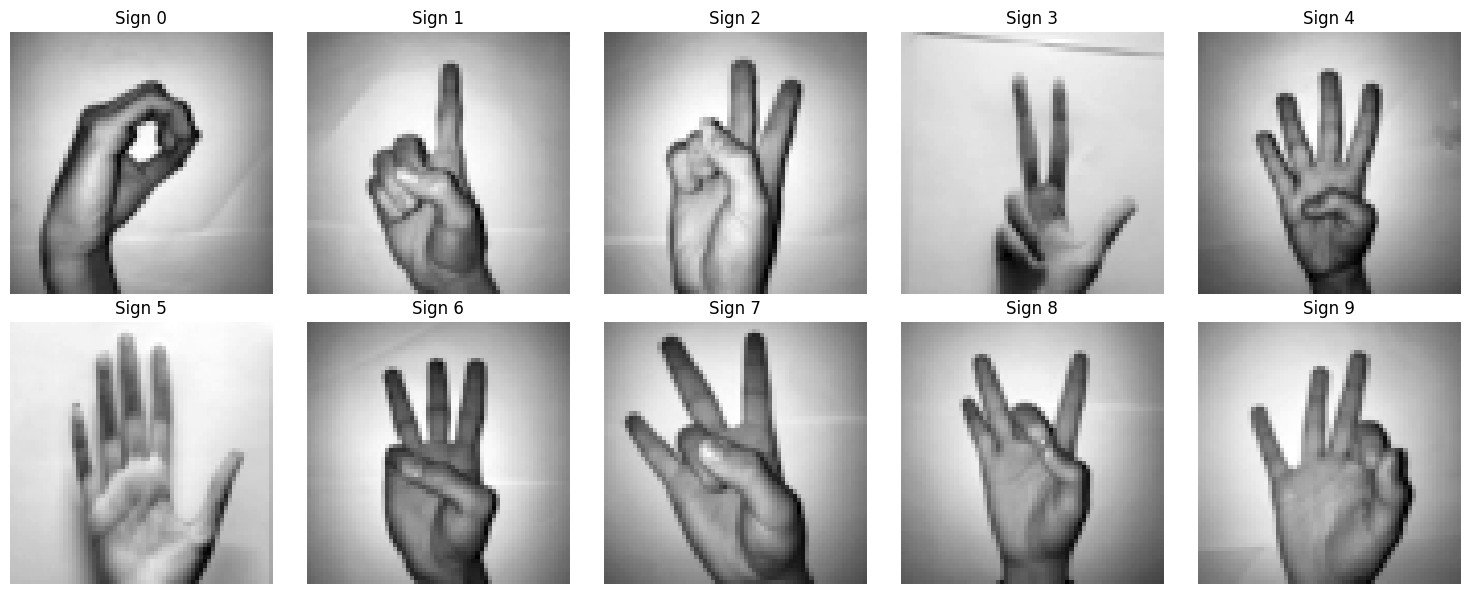

In [ ]:
import matplotlib.pyplot as plt

# Index gambar yang dipilih
image_index_list = [260, 900, 1800, 1600, 1400, 2061, 700, 500, 1111, 100]

# Buat grid 2 baris × 5 kolom
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[image_index_list[i]], cmap='gray')
    ax.set_title(f"Sign {i}", fontsize=12)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)  # aktifkan bingkai

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from scipy import ndimage
from skimage.feature import local_binary_pattern
from skimage.filters import gabor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Memuat dataset, mempersiapkan dataset untuk pemrosesan lebih lanjut, dan menyediakan fallback apabila tidak ditemukan
def load_dataset():
    """Load and prepare the hand sign dataset"""
    print("Loading dataset...")

    try:
        X = np.load('dataset/Sign-language-digits-dataset/X.npy')
        Y = np.load('dataset/Sign-language-digits-dataset/Y.npy')
        Y = np.argmax(Y, axis=1)  # Convert one-hot to class labels

        print(f"Dataset loaded successfully!")
        print(f"Dataset shape: X={X.shape}, Y={Y.shape}")
        print(f"Classes: {np.unique(Y)} (Total: {len(np.unique(Y))} classes)")
        print(f"Class distribution: {dict(zip(*np.unique(Y, return_counts=True)))}")

        return X, Y

    except FileNotFoundError:
        print("Dataset files not found. Using synthetic data for demonstration...")
        # Create synthetic data for testing
        X = np.random.randint(0, 256, (2000, 64, 64), dtype=np.uint8)
        Y = np.random.randint(0, 10, 2000)
        return X, Y

##PREPROCESSING

Pada tahap ini dilakukan proses preprocessing terhadap citra gestur tangan sebelum dilakukan ekstraksi fitur. Preprocessing bertujuan untuk meningkatkan kualitas dan konsistensi data agar model pembelajaran mesin dapat bekerja secara optimal. Adapun beberapa langkah preprocessing yang dilakukan adalah sebagai berikut:


*   **Normalisasi**: Proses normalisasi dilakukan dengan mengubah nilai intensitas piksel ke dalam rentang [0, 1].
*   **Histogram Equalization**: Diterapkan untuk meningkatkan kontras pada citra. Dengan menyebarkan nilai intensitas piksel secara lebih merata.
*   **Gaussian Blur**: Gaussian blur digunakan untuk mereduksi noise atau gangguan yang tidak relevan pada citra. Dengan menerapkan filter Gaussian, citra menjadi lebih halus, sehingga variasi lokal yang kecil dapat dikurangi dan bentuk global dari gestur tangan menjadi lebih menonjol.


In [ ]:
# Dilakukannya normalisasi sederhana untuk memastikan nilai pixel dalam rentang [0, 1]
def simple_normalize(image):
    """Simple but effective normalization"""
    img = image.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# Menerepkan Histogram Equalization untuk mendistribusi intensitas pixel
def histogram_equalization(image):
    """Simple histogram equalization"""
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    equalized = np.interp(image.flatten(), bins[:-1], cdf_normalized)
    return equalized.reshape(image.shape).astype(np.uint8)

# Menerapkan Gaussian Blur untuk mengurangi noise
def apply_gaussian_blur(image, sigma=1.0):
    """Apply Gaussian blur using scipy"""
    return ndimage.gaussian_filter(image, sigma=sigma)

# Melakukan Preprocessing pada suatu gambar
def preprocess_single_image(image):
    """Preprocess a single image and return before/after"""
    original = image.copy()

    # 1. Simple normalization
    processed = simple_normalize(image)

    # 2. Histogram equalization for better contrast
    image_uint8 = (processed * 255).astype(np.uint8)
    image_eq = histogram_equalization(image_uint8)
    processed = simple_normalize(image_eq)

    # 3. Light Gaussian blur to reduce noise
    processed = apply_gaussian_blur(processed, sigma=0.8)

    return original, processed

# Memvisualisasikan hasil tahapan preprocessing, menampilkan gambar asli dan yang sudah di preproses
def visualize_preprocessing(X, num_samples=5):
    """Visualize preprocessing steps for representative samples"""
    print("Visualizing preprocessing steps...")

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Select random samples
    indices = np.random.choice(len(X), num_samples, replace=False)

    for i, idx in enumerate(indices):
        original, processed = preprocess_single_image(X[idx])

        # Original image
        axes[0, i].imshow(original, cmap='gray')
        axes[0, i].set_title(f'Original {idx}')
        axes[0, i].axis('off')

        # Processed image
        axes[1, i].imshow(processed, cmap='gray')
        axes[1, i].set_title(f'Processed {idx}')
        axes[1, i].axis('off')

    plt.suptitle('Preprocessing: Before vs After', fontsize=16)
    plt.tight_layout()
    plt.show()

# Melakukan tahapan preprocessing kepada seluruh gambar dalam dataset
def preprocess_images(X):
    """Preprocess all images"""
    print("Applying preprocessing to all images...")

    X_processed = np.zeros_like(X, dtype=np.float32)
    n_samples = X.shape[0]

    for i in range(n_samples):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{n_samples}")

        _, X_processed[i] = preprocess_single_image(X[i])

    print("Preprocessing completed!")
    return X_processed


##FEATURE EXTRACTION

Tahap selanjutnya adalah Feature Extraction. Tujuan dari tahap ini adalah mengubah citra input menjadi representasi numerik berupa vektor fitur, yang dapat merepresentasikan berbagai aspek visual penting dari gestur tangan. Pendekatan yang digunakan, yakni multi domain memiliki beberapa kategori yaitu:


*   **Statistical Features**: Fitur statistik dihitung dari distribusi nilai intensitas piksel pada citra grayscale.
*   **Gradient Features**: Untuk menangkap informasi perubahan intensitas secara lokal dan mendeteksi tepi atau kontur objek, digunakan operator Sobel pada arah horizontal dan vertikal.
*   **Texture Features**: Untuk menangkap pola tekstur lokal dari permukaan tangan, digunakan metode Local Binary Pattern dengan radius 1 dan 8 titik sampel.





In [ ]:
# Mengekstak fitur raw pada pixel dengan cara flatten pada array gambar
def extract_pixel_features(images):
    """Extract raw pixel features"""
    print("Extracting pixel features...")
    n_samples = images.shape[0]
    flattened = images.reshape(n_samples, -1)
    return flattened
'''
Mengekstrak fitur statistik dari gambar
Fitur yang Diekstrak:
  Statistik dasar (mean, std, var, min, max, median)
  Percentile (25th, 75th)
  Histogram (16 bins)
  Moments (skewness, kurtosis)
'''
def extract_statistical_features(images):
    """Extract statistical features"""
    print("Extracting statistical features...")

    features = []
    n_samples = images.shape[0]

    for i in range(n_samples):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{n_samples}")

        img = images[i]

        # Basic statistics
        feat = [
            np.mean(img), np.std(img), np.var(img),
            np.min(img), np.max(img), np.median(img),
            np.percentile(img, 25), np.percentile(img, 75),
        ]

        # Histogram features
        hist, _ = np.histogram(img, bins=16, range=(0, 1))
        hist = hist / np.sum(hist)
        feat.extend(hist)

        # Moments
        feat.extend([
            np.mean(img**2),  # Second moment
            np.mean((img - np.mean(img))**3) / (np.std(img)**3 + 1e-8),  # Skewness
            np.mean((img - np.mean(img))**4) / (np.std(img)**4 + 1e-8) - 3,  # Kurtosis
        ])

        features.append(feat)

    return np.array(features)

'''
Mengekstrak fitur gradien
Fitur yang Diekstrak:
  Magnitude gradien
  Statistik gradien (mean, std, max)
  Proporsi pixel di atas rata-rata
'''
def extract_gradient_features(images):
    """Extract gradient features"""
    print("Extracting gradient features...")

    features = []
    n_samples = images.shape[0]

    for i in range(n_samples):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{n_samples}")

        img = images[i]

        # Sobel gradients
        grad_x = ndimage.sobel(img, axis=1)
        grad_y = ndimage.sobel(img, axis=0)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        feat = [
            np.mean(magnitude), np.std(magnitude),
            np.max(magnitude),
            np.sum(magnitude > np.mean(magnitude)) / magnitude.size,
        ]

        features.append(feat)

    return np.array(features)

'''
Mengekstrak fitur tekstur menggunakan Local Binary Pattern
dengan parameter Radius 1, n_points 8, dan method uniform
'''
def extract_texture_features(images):
    """Extract texture features using LBP"""
    print("Extracting texture features...")

    features = []
    n_samples = images.shape[0]

    radius = 1
    n_points = 8 * radius

    for i in range(n_samples):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{n_samples}")

        img = images[i]
        img_uint8 = (img * 255).astype(np.uint8)

        # Local Binary Pattern
        lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')

        # LBP histogram
        n_bins = n_points + 2
        lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist / np.sum(lbp_hist)

        features.append(lbp_hist)

    return np.array(features)


# Mengekstrak dan mengcombine seluruh fitur
def extract_comprehensive_features(images):
    """Extract all features and combine them"""
    print("Extracting comprehensive features...")

    pixel_feat = extract_pixel_features(images)
    stat_feat = extract_statistical_features(images)
    grad_feat = extract_gradient_features(images)
    texture_feat = extract_texture_features(images)

    print(f"Feature shapes:")
    print(f"  Pixel features: {pixel_feat.shape}")
    print(f"  Statistical features: {stat_feat.shape}")
    print(f"  Gradient features: {grad_feat.shape}")
    print(f"  Texture features: {texture_feat.shape}")

    # Combine all features
    all_features = np.hstack([pixel_feat, stat_feat, grad_feat, texture_feat])

    print(f"Combined features shape: {all_features.shape}")

    # Handle NaN values
    nan_mask = np.isnan(all_features)
    if np.any(nan_mask):
        print(f"Found {np.sum(nan_mask)} NaN values, replacing with 0")
        all_features[nan_mask] = 0

    return all_features

# Menerapkan PCA untuk dimentionality reduction
def apply_pca(X_train, X_test, n_components=0.95):
    """Apply PCA for dimensionality reduction"""
    print(f"Applying PCA with {n_components} variance retention...")

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print(f"PCA results:")
    print(f"  Original dimensions: {X_train.shape[1]}")
    print(f"  Reduced dimensions: {X_train_pca.shape[1]}")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    return X_train_pca, X_test_pca, pca

# pengaplikasian feature selection
def apply_feature_selection(X_train, X_test, y_train, k=500):
    """Apply feature selection"""
    print(f"Applying feature selection (top {k} features)...")

    selector = SelectKBest(score_func=f_classif, k=min(k, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    print(f"Feature selection results:")
    print(f"  Selected features: {X_train_selected.shape[1]} / {X_train.shape[1]}")

    return X_train_selected, X_test_selected, selector



##MODEL TRAINING AND EVALUATION

Metode yang digunakan adalah Support Vector Machine (SVM).
Konfigurasi model:

*   Kernel Radial Basis Function

Dipilih karena kemampuan menangani hubungan non-linear antar feature

*   Parameter C = 10

Mengontrol trade-off antara margin classification dan classification error

*   Parameter Gamma = 'scale'

Mengontrol pengaruh masing-masing titik training

*   Probability = true

Mengaktifkan estimasi probabilitas kelas

*   Random state = 42




In [ ]:
def train_svm_classifier(X_train, X_test, y_train, y_test):
    """Train SVM classifier with RBF kernel"""
    print("Training SVM classifier with RBF kernel...")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM
    svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True)
    svm_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"SVM Training completed!")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return svm_model, scaler, y_pred, accuracy


In [ ]:
# Menampilkan evaluasi dari model
def evaluate_model(y_test, y_pred, accuracy):
    """Evaluate model performance"""
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)

    print(f"\nDetailed Classification Report:")
    print("-" * 50)
    print(classification_report(y_test, y_pred,
                              target_names=[f'Digit {i}' for i in range(10)]))

# Memvisualisasikan confusion matrix dari performa model
def plot_confusion_matrix(y_test, y_pred, accuracy):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Digit {i}' for i in range(10)],
                yticklabels=[f'Digit {i}' for i in range(10)])

    plt.title(f'Confusion Matrix - SVM RBF\nAccuracy: {accuracy:.3f} ({accuracy*100:.1f}%)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


##MODEL EXPORT

Tahap ini melakukan export model yang telah ditrain kedalam format pickle dan juga menyimpan informasi model kedalam format text

In [ ]:
import pickle
import numpy as np

# Save model yang sudah ditrain ke format pickle dan juga save informasi dari model ke format test
def export_model(svm_model, scaler, pca, selector, accuracy):
    """Export trained model and preprocessing components using pickle"""
    print("\nExporting trained model...")

    model_data = {
        'svm_model': svm_model,
        'scaler': scaler,
        'pca': pca,
        'selector': selector,
        'accuracy': accuracy,
        'model_info': {
            'type': 'SVM with RBF kernel',
            'preprocessing': 'Normalization + Histogram Equalization + Gaussian Blur',
            'features': 'Pixel + Statistical + Gradient + Texture (LBP)',
            'dimensionality_reduction': 'PCA + Feature Selection',
            'final_accuracy': f'{accuracy:.4f} ({accuracy*100:.2f}%)'
        }
    }

    # Save model with pickle
    model_filename = 'hand_sign_svm_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model_data, f)

    print(f"Model exported successfully as '{model_filename}'")
    print(f"Model accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Save model info as text
    info_filename = 'model_info.txt'
    with open(info_filename, 'w') as f:
        f.write("Hand Sign Classification Model - SVM RBF\n")
        f.write("="*50 + "\n\n")
        f.write(f"Model Type: {model_data['model_info']['type']}\n")
        f.write(f"Preprocessing: {model_data['model_info']['preprocessing']}\n")
        f.write(f"Features: {model_data['model_info']['features']}\n")
        f.write(f"Dimensionality Reduction: {model_data['model_info']['dimensionality_reduction']}\n")
        f.write(f"Final Accuracy: {model_data['model_info']['final_accuracy']}\n")
        f.write(f"\nExport Date: {np.datetime64('now')}\n")

    print(f"📝 Model info saved as '{info_filename}'")

    return model_filename

# Memuat model yang telah disimpan dan melakukan prediksi baru
def load_and_predict(model_filename, new_image):
    """Function to load model and make predictions on new images"""
    print(f"Loading model from '{model_filename}'...")

    # Load model
    model_data = joblib.load(model_filename)
    svm_model = model_data['svm_model']
    scaler = model_data['scaler']
    pca = model_data['pca']
    selector = model_data['selector']

    # Preprocess new image
    _, processed_image = preprocess_single_image(new_image)

    # Extract features
    features = extract_comprehensive_features(processed_image.reshape(1, *processed_image.shape))

    # Apply PCA and feature selection
    features_pca = pca.transform(features)
    features_selected = selector.transform(features_pca)

    # Scale features
    features_scaled = scaler.transform(features_selected)

    # Make prediction
    prediction = svm_model.predict(features_scaled)[0]
    probability = svm_model.predict_proba(features_scaled)[0]
    confidence = np.max(probability)

    print(f"Predicted digit: {prediction}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

    return prediction, confidence


##MAIN EXECUTION

Loading dataset...
Dataset loaded successfully!
Dataset shape: X=(2062, 64, 64), Y=(2062,)
Classes: [0 1 2 3 4 5 6 7 8 9] (Total: 10 classes)
Class distribution: {np.int64(0): np.int64(204), np.int64(1): np.int64(205), np.int64(2): np.int64(206), np.int64(3): np.int64(207), np.int64(4): np.int64(206), np.int64(5): np.int64(208), np.int64(6): np.int64(207), np.int64(7): np.int64(206), np.int64(8): np.int64(206), np.int64(9): np.int64(207)}

Visualizing Preprocessing
Visualizing preprocessing steps...


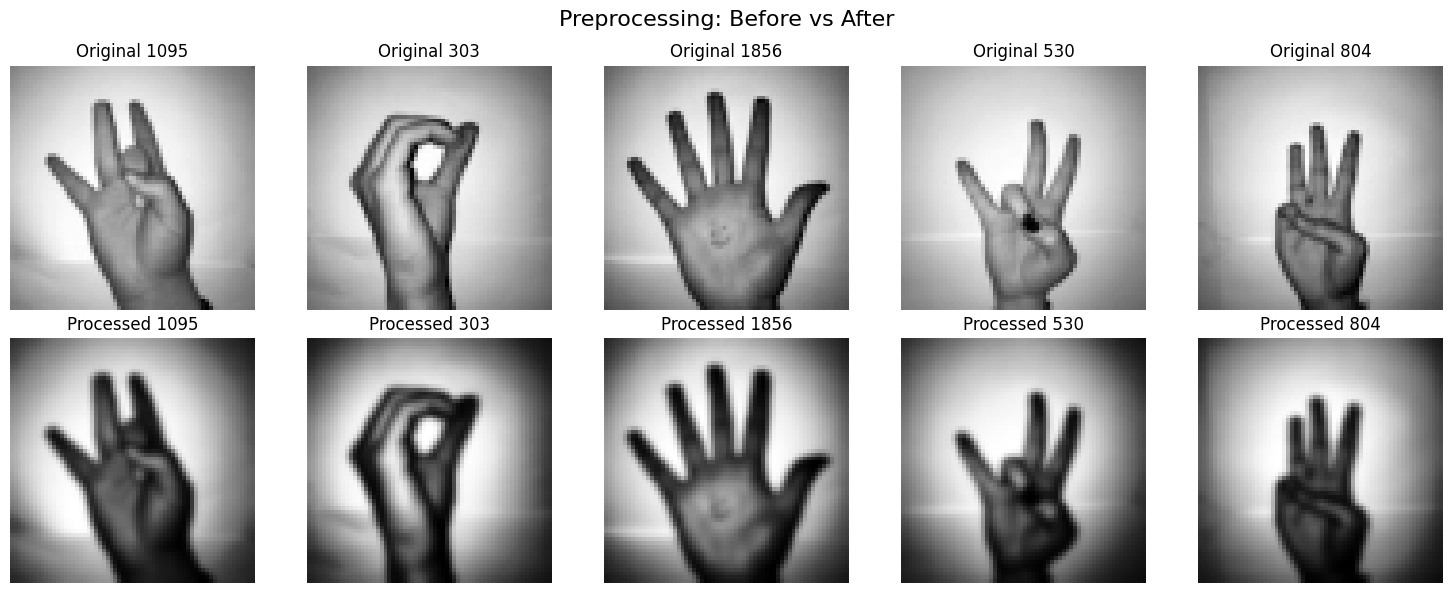


Preprocessing 2062 images
Applying preprocessing to all images...
Processing image 1/2062
Processing image 501/2062
Processing image 1001/2062
Processing image 1501/2062
Processing image 2001/2062
Preprocessing completed!

 Extracting features
Extracting comprehensive features...
Extracting pixel features...
Extracting statistical features...
Processing image 1/2062
Processing image 501/2062
Processing image 1001/2062
Processing image 1501/2062
Processing image 2001/2062
Extracting gradient features...
Processing image 1/2062
Processing image 501/2062
Processing image 1001/2062
Processing image 1501/2062
Processing image 2001/2062
Extracting texture features...
Processing image 1/2062
Processing image 501/2062
Processing image 1001/2062
Processing image 1501/2062
Processing image 2001/2062
Feature shapes:
  Pixel features: (2062, 4096)
  Statistical features: (2062, 27)
  Gradient features: (2062, 4)
  Texture features: (2062, 10)
Combined features shape: (2062, 4137)

Splitting datas

In [ ]:
X, y = load_dataset()

print(f"\nVisualizing Preprocessing")
visualize_preprocessing(X, num_samples=5)

print(f"\nPreprocessing {X.shape[0]} images")
X_processed = preprocess_images(X)

print(f"\n Extracting features")
features = extract_comprehensive_features(X_processed)

print(f"\nSplitting dataset")
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nApplying PCA...")
X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, n_components=0.95)

print(f"\nApplying feature selection...")
X_train_final, X_test_final, selector = apply_feature_selection(
    X_train_pca, X_test_pca, y_train, k=500
)





Training SVM classifier...
Training SVM classifier with RBF kernel...
SVM Training completed!
Accuracy: 0.8329 (83.29%)

Evaluating results...

MODEL EVALUATION RESULTS

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     Digit 0       0.89      0.83      0.86        41
     Digit 1       0.89      0.95      0.92        41
     Digit 2       0.72      0.68      0.70        41
     Digit 3       0.78      0.76      0.77        41
     Digit 4       0.90      0.90      0.90        41
     Digit 5       0.89      0.95      0.92        42
     Digit 6       0.76      0.81      0.78        42
     Digit 7       0.89      0.78      0.83        41
     Digit 8       0.72      0.76      0.74        41
     Digit 9       0.90      0.90      0.90        42

    accuracy                           0.83       413
   macro avg       0.83      0.83      0.83       413
weighted avg       0.83      0.83      0.8

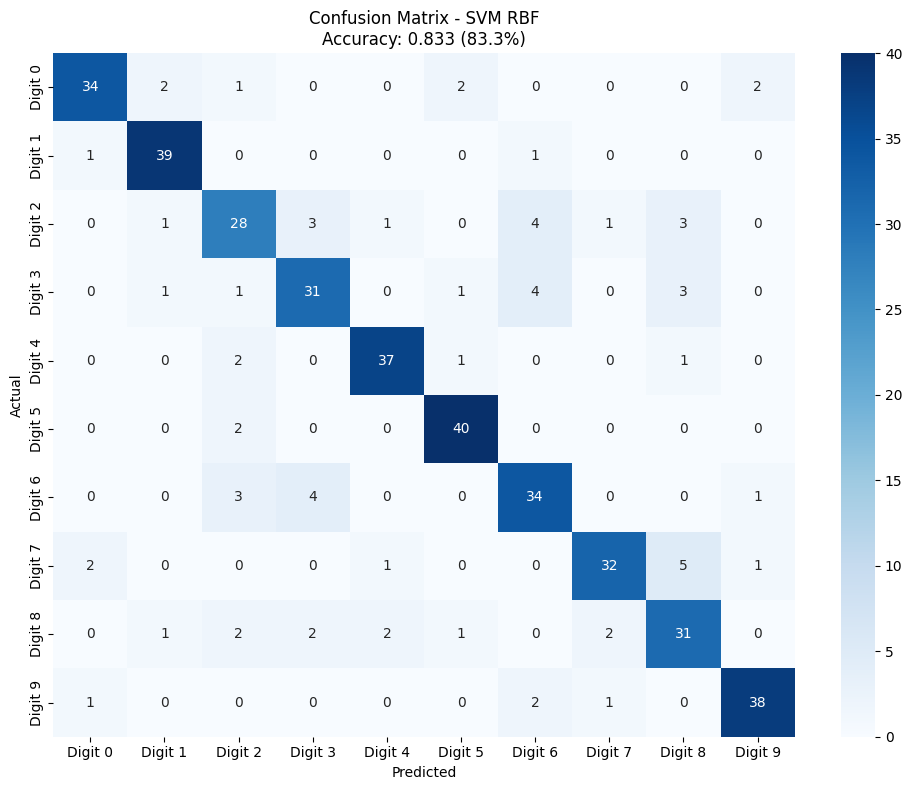


FINAL SUMMARY
Model: SVM with RBF kernel
Accuracy: 0.8329 (83.29%)


In [ ]:
print(f"\nTraining SVM classifier...")
svm_model, scaler, y_pred, accuracy = train_svm_classifier(
    X_train_final, X_test_final, y_train, y_test
)

print(f"\nEvaluating results...")
evaluate_model(y_test, y_pred, accuracy)

print(f"\nGenerating confusion matrix...")
plot_confusion_matrix(y_test, y_pred, accuracy)

print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
print(f"Model: SVM with RBF kernel")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


In [ ]:
print(f"\nExporting model...")
model_filename = export_model(svm_model, scaler, pca, selector, accuracy)


Exporting model...

Exporting trained model...
Model exported successfully as 'hand_sign_svm_model.pkl'
Model accuracy: 0.8329 (83.29%)
📝 Model info saved as 'model_info.txt'
